# Getting started with Task 1

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the notebook directory

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## The PTB Diagnostic ECG Database

- Number of Samples: 14552
- Number of Categories: 2
- Sampling Frequency: 125Hz
- Data Source: Physionet's PTB Diagnostic Database
- ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf))
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0
The last time value is :  1488.0


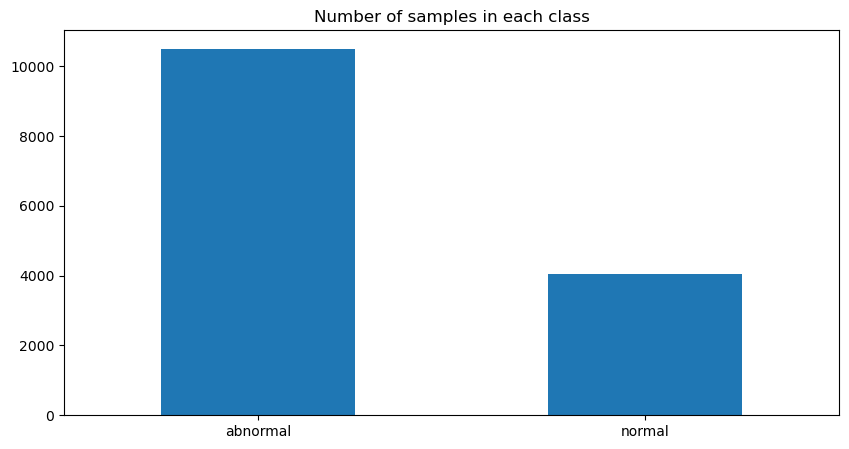

In [2]:
df_ptbd_normal = pd.read_csv("../ecg_dataset/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv("../ecg_dataset/ptbdb_abnormal.csv", header = None)

# print shapes of the dataframes
print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
# print one example of the last column
print("Class : ", df_ptbd_normal.iloc[:, -1][0])
print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
# print one example of the last column
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal", 
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

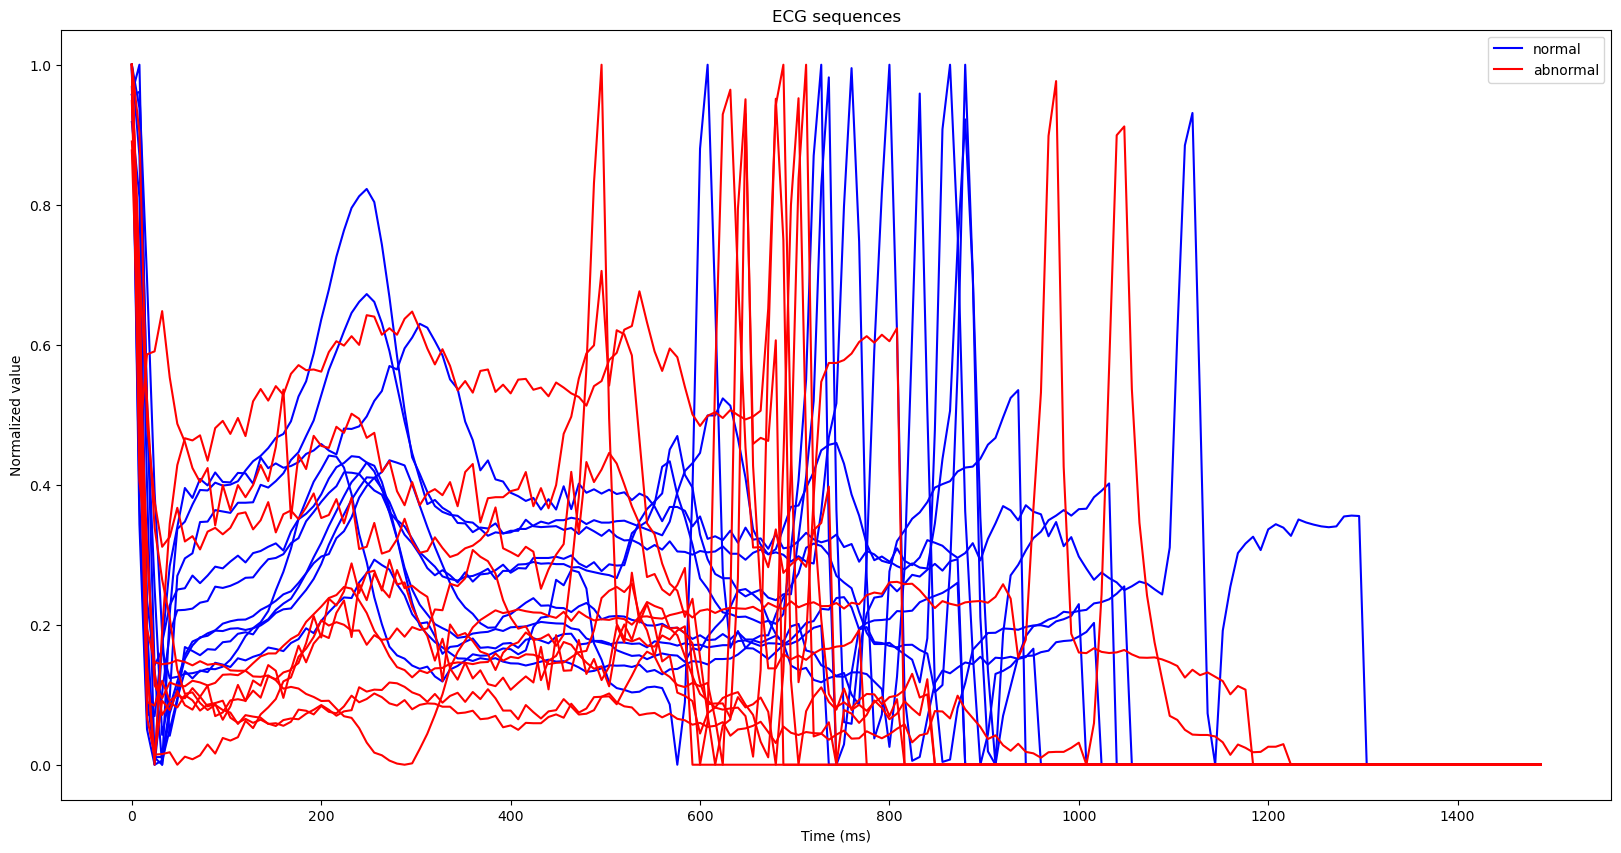

In [3]:
# plot a a row of the dataframe
# select 10 random sequences with class 0 (normal) and 10 with class 1 (abnormal)
df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(10)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(10)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences
for i in range(df_ptbd_normal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue", label = "normal")
    else:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1],color = "blue")
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red", label = "abnormal")
    else:   
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

# Processing Raw ECG signal as Inputs


In [9]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset


In [13]:
RANDOM_STATE = 0

df_ptbd_normal = pd.read_csv("../ecg_dataset/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv("../ecg_dataset/ptbdb_abnormal.csv", header = None)

# Split the normal and abnormal datasets into train, validation (CV), and test sets
X_train_normal, X__normal, y_train_normal, y__normal = train_test_split(
    df_ptbd_normal.iloc[:, :-1], df_ptbd_normal.iloc[:, -1], test_size=0.20, random_state=RANDOM_STATE)
X_train_abnormal, X__abnormal, y_train_abnormal, y__abnormal = train_test_split(
    df_ptbd_abnormal.iloc[:, :-1], df_ptbd_abnormal.iloc[:, -1], test_size=0.20, random_state=RANDOM_STATE)

X_cv_normal, X_test_normal, y_cv_normal, y_test_normal = train_test_split(
    X__normal, y__normal, test_size=0.5, random_state=RANDOM_STATE)
X_cv_abnormal, X_test_abnormal, y_cv_abnormal, y_test_abnormal = train_test_split(
    X__abnormal, y__abnormal, test_size=0.5, random_state=RANDOM_STATE)

# Determine the size for undersampling (number of samples in the smaller training class)
min_train_size = min(len(X_train_normal), len(X_train_abnormal))

# Perform undersampling on the training set
X_train_normal_under = X_train_normal.sample(n=min_train_size, random_state=42)
y_train_normal_under = y_train_normal.sample(n=min_train_size, random_state=42)

X_train_abnormal_under = X_train_abnormal.sample(n=min_train_size, random_state=42)
y_train_abnormal_under = y_train_abnormal.sample(n=min_train_size, random_state=42)

# Combine the undersampled training data
X_train = pd.concat([X_train_normal_under, X_train_abnormal_under], axis=0)
y_train = pd.concat([y_train_normal_under, y_train_abnormal_under], axis=0)

# Shuffle the combined training data
X_train, y_train = X_train.sample(frac=1, random_state=42).reset_index(drop=True), y_train.sample(frac=1, random_state=42).reset_index(drop=True)
# Convert data to NumPy arrays
X_train_np = X_train.values
y_train_np = y_train.values

X_cv = np.concatenate((X_cv_normal, X_cv_abnormal))
y_cv = np.concatenate((y_cv_normal, y_cv_abnormal))

X_test = np.concatenate((X_test_normal, X_test_abnormal))
y_test = np.concatenate((y_test_normal, y_test_abnormal))

# Print the shapes of the combined datasets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

print(f"Shape of X_cv: {X_cv.shape}")
print(f"Shape of y_cv: {y_cv.shape}")

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)

X_cv_tensor = torch.tensor(X_cv, dtype=torch.float32).unsqueeze(1)
y_cv_tensor = torch.tensor(y_cv, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



Shape of X_train: (6472, 187)
Shape of y_train: (6472,)
Shape of X_cv: (1456, 187)
Shape of y_cv: (1456,)
Shape of X_test: (1456, 187)
Shape of y_test: (1456,)


In [14]:
# Create DataLoader for training, validation, and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
cv_dataset = TensorDataset(X_cv_tensor, y_cv_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
cv_loader = DataLoader(cv_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

**Next, Build your model, Train, Test !**

# Processing Transformed ECG - GAF Images as Inputs


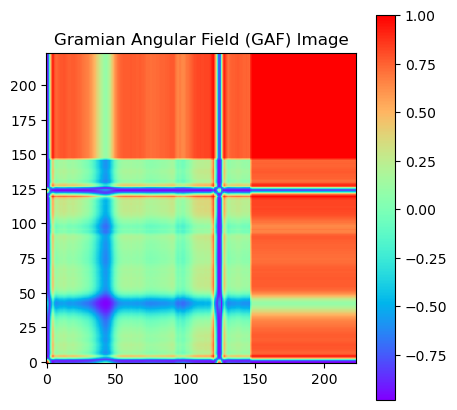

In [18]:
# Function to transform ECG signal to GAF Image
from skimage.transform import resize
from pyts.image import GramianAngularField


def transform_ecg_to_gaf(signal, target_size=(224, 224)):
    # Ensure signal is a 1D sequence
    if not isinstance(signal, (list, np.ndarray)):
        raise ValueError("Expected signal to be a list or 1D numpy array.")
    
    # Set image size to the length of the signal if it's less than 224
    image_size = min(len(signal), 224)
    gaf = GramianAngularField(image_size=image_size, method='summation')
    signal = np.array(signal).reshape(1, -1)  # Ensure the signal is a 1D numpy array
    gaf_image = gaf.fit_transform(signal)[0]

    # Resize the image if it's not 224x224
    if gaf_image.shape != target_size:
        gaf_image = resize(gaf_image, target_size, mode='reflect', anti_aliasing=True)

    return gaf_image

# Example transformation for a chosen ECG signal
first_ecg_signal = df_ptbd_normal.iloc[0, :-1].values  # Selecting the 101st record
gaf_image = transform_ecg_to_gaf(first_ecg_signal)

# Plot the GAF image
plt.figure(figsize=(5, 5))
plt.imshow(gaf_image, cmap='rainbow', origin='lower')
plt.title("Gramian Angular Field (GAF) Image")
plt.colorbar()
plt.show()

## Save arrays

Save arrays so you dont have to generate each time

Comment after running once!

In [23]:
print(type(y_cv))

<class 'numpy.ndarray'>


In [25]:
# Apply the transformation to the signals in X_train, X_cv, and X_test
X_train_gaf = np.array([transform_ecg_to_gaf(signal) for signal in X_train.values])  # X_train is a DataFrame, so .values is used
X_cv_gaf = np.array([transform_ecg_to_gaf(signal) for signal in X_cv])  # X_cv is already a NumPy array
X_test_gaf = np.array([transform_ecg_to_gaf(signal) for signal in X_test])  # X_test is already a NumPy array

# Step 3: Flatten the GAF Images to 1D Feature Vectors
X_train_flat = X_train_gaf.reshape(X_train_gaf.shape[0], -1)
X_cv_flat = X_cv_gaf.reshape(X_cv_gaf.shape[0], -1)
X_test_flat = X_test_gaf.reshape(X_test_gaf.shape[0], -1)

# Convert labels to 1D arrays (if necessary)
y_train = y_train.ravel()
y_cv = y_cv.ravel()        # Flatten to 1D array
y_test = y_test.ravel()    # Flatten to 1D array


import sys

# Function to calculate the memory usage of a variable
def memory_usage(var):
    return sys.getsizeof(var) / (1024**2)  # Convert bytes to megabytes

# Assuming your variables are already defined (X_train_gaf, X_cv_gaf, X_test_gaf, etc.)
# Example usage:
memory_usage_X_train_gaf = memory_usage(X_train_gaf)
memory_usage_X_cv_gaf = memory_usage(X_cv_gaf)
memory_usage_X_test_gaf = memory_usage(X_test_gaf)
memory_usage_X_train_flat = memory_usage(X_train_flat)
memory_usage_X_cv_flat = memory_usage(X_cv_flat)
memory_usage_X_test_flat = memory_usage(X_test_flat)
memory_usage_y_train = memory_usage(y_train)
memory_usage_y_cv = memory_usage(y_cv)
memory_usage_y_test = memory_usage(y_test)

print(f"Memory usage of X_train_gaf: {memory_usage_X_train_gaf:.2f} MB")
print(f"Memory usage of X_cv_gaf: {memory_usage_X_cv_gaf:.2f} MB")
print(f"Memory usage of X_test_gaf: {memory_usage_X_test_gaf:.2f} MB")
print(f"Memory usage of X_train_flat: {memory_usage_X_train_flat:.2f} MB")
print(f"Memory usage of X_cv_flat: {memory_usage_X_cv_flat:.2f} MB")
print(f"Memory usage of X_test_flat: {memory_usage_X_test_flat:.2f} MB")
print(f"Memory usage of y_train: {memory_usage_y_train:.2f} MB")
print(f"Memory usage of y_cv: {memory_usage_y_cv:.2f} MB")
print(f"Memory usage of y_test: {memory_usage_y_test:.2f} MB")

# Assuming you have the arrays X_train_flat, X_cv_flat, X_test_flat, y_train, y_cv, y_test already defined

# Save the flattened arrays and labels to .npy files
np.save('task1_X_train_flat.npy', X_train_flat)
np.save('task1_X_cv_flat.npy', X_cv_flat)
np.save('task1_X_test_flat.npy', X_test_flat)
np.save('task1_y_train.npy', y_train)
np.save('task1_y_cv.npy', y_cv)
np.save('task1_y_test.npy', y_test)

print("Flattened GAF images and labels have been saved successfully with 'task1_' prefix.")

Memory usage of X_train_gaf: 2477.56 MB
Memory usage of X_cv_gaf: 557.38 MB
Memory usage of X_test_gaf: 557.38 MB
Memory usage of X_train_flat: 0.00 MB
Memory usage of X_cv_flat: 0.00 MB
Memory usage of X_test_flat: 0.00 MB
Memory usage of y_train: 0.00 MB
Memory usage of y_cv: 0.00 MB
Memory usage of y_test: 0.00 MB
Flattened GAF images and labels have been saved successfully with 'task1_' prefix.


In [26]:
# Load the flattened arrays and labels from .npy files with 'task1_' prefix
X_train_flat = np.load('task1_X_train_flat.npy')
X_cv_flat = np.load('task1_X_cv_flat.npy')
X_test_flat = np.load('task1_X_test_flat.npy')
y_train = np.load('task1_y_train.npy')
y_cv = np.load('task1_y_cv.npy')
y_test = np.load('task1_y_test.npy')

print("Flattened GAF images and labels have been loaded successfully with 'task1_' prefix.")

Flattened GAF images and labels have been loaded successfully with 'task1_' prefix.
